![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# PEC 3: Noviembre 2019

## Extracción de conocimiento de fuentes de datos heterogéneas mediante Spark SQL, RDDs y GraphFrames

En esta práctica vamos a introducir estructuras de datos más complejas que las vistas hasta ahora, donde los campos pueden a su vez tener campos anidados. En concreto utilizaremos datos de twitter capturados en el contexto de las elecciones generales en España del 28 de Abril de 2019. La práctica está estructurada de la siguiente manera:
- **Parte 0:** Configuración del entorno
- **Parte 1:** Introducción a data frames estructurados y cómo operar extraer información *(1.5 puntos)*
    - **Parte 1.1:** Importar los datos *(0.25 puntos)*
    - **Parte 1.2:** *Queries* sobre sobre data frames complejos *(1.25 puntos)*
        - **Parte 1.2.1:** Queries SQL *(0.5 puntos)*
        - **Parte 1.2.2:** Queries sobre el pipeline *(0.75 puntos)*
- **Parte 2:** Bases de datos HIVE y operaciones complejas *(3.5 puntos)*
    - **Parte 2.1:** Bases de datos Hive *(0.25 puntos)*
    - **Parte 2.2:** Más allá de las transformaciones SQL *(2.75 puntos)*
        - **Parte 2.2.1:** Tweets por población  *(1.25 puntos)*
            - **Parte 2.2.1.1:** Utilizando SQL *(0.25 puntos)*
            - **Parte 2.2.1.2:** Utilizando RDD *(1 punto)*
        - **Parte 2.2.2:** Contar hashtags *(1.5 puntos)*
- **Parte 3:** Sampling *(3 Puntos)*
    - **Parte 3.1:** Homogéneo *(1 punto)*
    - **Parte 3.2:** Estratificado *(1.5 puntos)*
- **Parte 4**: Introducción a los datos relacionales *(2 puntos)*
    - **Parte 4.1:** Generar la red de retweets *(1 punto)*
        - **Parte 4.1.1**: Construcción de la edgelist *(0.5 puntos)*
        - **Parte 4.1.2**: Centralidad de grado *(0.5 puntos)*
    - **Parte 4.2:** Análisis de redes utilitzando GraphFrames *(1 punto)*
        - **Parte 4.2.1:** Crear un graph frame (0.5 puntos)
        - **Parte 4.2.2:** Centralidad PageRank (0.5 puntos)

## **Parte 0:** Configuración del entorno

In [1]:
import findspark
findspark.init()

In [2]:
import re
import os
import pandas as pd
from matplotlib import pyplot as plt
from math import floor
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import Row

In [3]:
SUBMIT_ARGS = "--packages graphframes:graphframes:0.7.0-spark2.4-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

conf = SparkConf()
conf.setMaster("local[1]")
# Introducid el nombre de la app PEC3_ seguido de vuestro nombre de usuario
conf.setAppName("PEC3_laurivsan")
sc = SparkContext(conf=conf)

## **Parte 1:** Introducción a data frames estructurados i operaciones sobre ellos.

Como ya se ha mencionado, en esta práctica vamos ha utilizar datos de Twitter que recolectamos durante las elecciones generales en España del 28 de abril de 2019. Como veremos, los tweets tienen una estructura interna bastante compleja que hemos simplificado un poco en esta práctica.

### **Parte 1.1:** Importar los datos

Lo primero que vamos ha aprender es cómo importar este tipo de datos a nuestro entorno. Uno de los tipos de archivos más comunes para guardar este formato de información es [la estructura JSON](https://en.wikipedia.org/wiki/JSON). Esta estructura permite guardar información en un texto plano de diferentes objetos siguiendo una estructura de diccionario donde cada campo tiene asignado una llave y un valor. La estructura puede ser anidada, o sea que una llave puede tener como valor otra estructura tipo diccionario.

Spark SQL permite leer datos de muchos formatos diferentes (como recordareis de la anterior práctica donde leímos un fichero CSV). En esta ocasión, se os pide que leáis un fichero JSON de la ruta ```/aula_M2.858/data/tweets28a_sample.json```. Este archivo contiene un pequeño *sample*, un 0.1% de la base de datos completa (en un siguiente apartado veremos cómo realizar este *sampleado*). En esta ocasión no se os pide especificar la estructura del data frame ya que la función de lectura la inferirá automáticamente.

In [4]:
sqlContext = SQLContext(sc)
tweets_sample = sqlContext.read.json("/aula_M2.858/data/tweets28a_sample.json")

print("Loaded dataset contains %d tweets" % tweets_sample.count())

Loaded dataset contains 27268 tweets


El siguiente paso es mostrar la estructura del dataset que acabamos de cargar. Recordad que podéis obtener la información acerca de cómo está estructurado el DataTable utilizando el método ```printSchema()```.

In [5]:
tweets_sample.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 |    

Podéis observar que la estructura del tweet contiene múltiples campos anidados. Teneis que familiarizaros con esta estructura ya que será la que utilizaremos durante toda la práctica. Recordad también que no todos los tweets tienen todos los campos, como por ejemplo la ubicación (campo ```place```). Cuando esto pasa el campo pasa a ser ```NULL```. Podéis ver mas información sobre este tipo de datos en [este enlace](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).

### **Parte 1.2:** *Queries* sobre sobre data frames complejos

En la anterior práctica hemos visto cómo hacer consultas sobre un dataset muy simple utilizando sentencias *SQL*. En esta parte vamos a refrescar los conceptos utilizados en la práctica anterior introduciendo algunos conceptos más avanzados y una nueva manera de trabajar sobre data tables.

#### **Parte 1.2.1:** Queries SQL

Como recordaréis de la parte 3 de la anterior PEC, el primer paso consiste en registrar la tabla en el contexto SQL comprobando primero si existe y borrándola en el caso que sea así. En este apartado se os pide que registréis la tabla ```tweets_sample``` que acabamos de cargar en el contexto sql bajo el mismo nombre ```tweets_sample```.

In [6]:
sqlContext.sql("DROP TABLE IF EXISTS tweets_sample")
sqlContext.registerDataFrameAsTable(tweets_sample, "tweets_sample")


Ahora se os pide que creeis una tabla ```users_agg``` con [la información agregada](https://www.w3schools.com/sql/sql_groupby.asp) de los usuarios que tengan definido su idioma (```user.lang```) como español (```es```). En concreto se os pide que la tabla contenga las siguientes columnas:
- **screen_name:** nombre del usuario
- **friends_count:** número máximo (ver nota) de personas a las que sigue
- **tweets:** número de tweets realizados
- **followers_count:** número máximo (ver nota) personas que siguen al usuario.

El orden en el cual se deben mostrar los registros es orden descendente acorde al número de tweets.

***Nota:*** es importante que os fijéis que el nombre de *friends* i *followers* puede diferir a lo largo de la adquisición de datos. En este caso vamos ha utilizar la función de agregación ```MAX``` sobre cada uno de estos campos para evitar segmentar el usuario en diversas instancias.

In [7]:
users_agg = sqlContext.sql("SELECT user.screen_name, max(user.friends_count) as friends_count, count(_id) as tweets, max(user.followers_count) as followers_count \
                            from tweets_sample where user IS NOT NULL \
                            group by user.screen_name order by tweets DESC")
users_agg.limit(10).show()

+---------------+-------------+------+---------------+
|    screen_name|friends_count|tweets|followers_count|
+---------------+-------------+------+---------------+
|       anaoromi|         6258|    16|           6774|
|    RosaMar6254|         6208|    14|           6245|
|        lyuva26|         3088|    13|           3732|
|     carrasquem|          147|    12|            215|
|PisandoFuerte10|         2795|    12|           1752|
|       jasalo54|         1889|    11|            689|
|  Angel15268471|         1053|    11|            277|
|    DuroBelinda|         5242|     9|           5778|
| locuspolitikus|        11261|     9|          10244|
|   Robi45852533|         4531|     9|           2530|
+---------------+-------------+------+---------------+



In [8]:
output = users_agg.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Imaginad ahora que queremos combinar la información que acabamos de generar con información acerca del número de veces que un usuario ha sido retuiteado. Para hacer este tipo de combinaciones necesitamos recurrir al [```JOIN``` de tablas](https://www.w3schools.com/sql/sql_join.asp). Primero debemos registrar la tabla que acabamos de generar en el contexto SQL. Recordad que primero debéis comprobar si la tabla existe y en caso afirmativo eliminarla. La tabla tenéis que registrarla bajo el nombre de ```user_agg```.

In [9]:
sqlContext.sql("DROP TABLE IF EXISTS user_agg")
sqlContext.registerDataFrameAsTable(users_agg, "user_agg")

Una vez registrada se pide que combinéis esta tabla y la tabla ```tweets_sample``` utilizando un ```INNER JOIN``` para obtener una nueva tabla con la siguiente información:
- ***screen_name:*** nombre de usuario
- ***friends_count:*** número máximo de personas a las que sigue
- ***followers_count:*** número máximo de personas que siguen al usuario.
- ***tweets:*** número de tweets realizados por el usuario.
- ***retweeted:*** número de retweets obtenidos por el usuario.
- ***ratio_tweet_retweeted:*** ratio de retweets por número de tweets publicados $\frac{retweets}{tweets}$

In [10]:
retweeted = sqlContext.sql("SELECT screen_name, friends_count, followers_count, tweets, count(tweets_sample.retweeted_status) as retweeted, count(tweets_sample.retweeted_status)/tweets as ratio_tweet_retweeted \
                            FROM user_agg INNER JOIN tweets_sample  ON user_agg.screen_name = tweets_sample.retweeted_status.user.screen_name \
                            GROUP BY user_agg.screen_name, friends_count, followers_count, tweets \
                            ORDER BY retweeted DESC")

retweeted.limit(10).show()

+---------------+-------------+---------------+------+---------+---------------------+
|    screen_name|friends_count|followers_count|tweets|retweeted|ratio_tweet_retweeted|
+---------------+-------------+---------------+------+---------+---------------------+
|           PSOE|        13635|         671073|     1|      155|                155.0|
|   CiudadanosCs|        92910|         511896|     1|      117|                117.0|
|  gabrielrufian|         4678|         641252|     2|       98|                 49.0|
|Front_Republica|           56|          28754|     2|       78|                 39.0|
|      JuntsXCat|          202|          88515|     1|       73|                 73.0|
|   PartidoPACMA|         1498|         232932|     1|       63|                 63.0|
|   pablocasado_|         4567|         238926|     1|       50|                 50.0|
| voxnoticias_es|         2146|          29582|     1|       44|                 44.0|
|    jordiborras|         2091|         168

In [11]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

#### **Parte 1.2.2:** Queries a través del pipeline

Las tablas de Spark SQL ofrecen otro mecanismo para aplicar las transformaciones y obtener resultados similares a los que se obtendría aplicando una consulta SQL. Por ejemplo utilizando el siguiente pipeline obtendremos el texto de todos los tweets en español:

```
tweets_sample.where("lang == 'es'").select("text")
```

Que es equivalente a la siguiente sentencia SQL:

```
SELECT text
FROM tweets_sample
WHERE lang == 'es'
```

Podéis consultar el [API de spark SQL](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html) para encontrar más información sobre como utilitzar las diferentes transformaciones en tablas.

En este ejercicio se os pide que repliquéis la query obtenida en el apartado anterior empezando por generar la tabla ```users_agg```. Podéis utilizar las transformaciones ```where```, ```select``` (o ```selectExpr```), ```groupBy```, ```count```, ```agg``` y ```orderBy```

In [12]:
users = tweets_sample.where("user IS NOT NULL").select("user")

users_agg = users.groupBy("user.screen_name")\
                 .agg({"user.followers_count": "max", "user.friends_count": "max", "user": "count"})\
                 .orderBy("count(user)",ascending=0)

users_agg.limit(10).show()

+---------------+------------------------------------------+-----------+----------------------------------------------+
|    screen_name|max(user.friends_count AS `friends_count`)|count(user)|max(user.followers_count AS `followers_count`)|
+---------------+------------------------------------------+-----------+----------------------------------------------+
|       anaoromi|                                      6258|         16|                                          6774|
|    RosaMar6254|                                      6208|         14|                                          6245|
|        lyuva26|                                      3088|         13|                                          3732|
|     carrasquem|                                       147|         12|                                           215|
|PisandoFuerte10|                                      2795|         12|                                          1752|
|       jasalo54|                       

Si os fijáis veréis que el nombre de las columnas no corresponde con el obtenido anteriormente, podéis cambiar el nombre de una columna determinada utilizando la transformación ```withColumnRenamed```. Cambiad el nombre de las columnas para que coincidan con el apartado anterior y guardadlas en una variable ```user_agg_new```.

In [13]:
users_agg_new = users_agg.withColumnRenamed("count(user)", "tweets")\
                         .withColumnRenamed("max(user.friends_count AS `friends_count`)", "friends_count")\
                         .withColumnRenamed("max(user.followers_count AS `followers_count`)", "followers_count")

users_agg_new.limit(10).show()

+---------------+-------------+------+---------------+
|    screen_name|friends_count|tweets|followers_count|
+---------------+-------------+------+---------------+
|       anaoromi|         6258|    16|           6774|
|    RosaMar6254|         6208|    14|           6245|
|        lyuva26|         3088|    13|           3732|
|     carrasquem|          147|    12|            215|
|PisandoFuerte10|         2795|    12|           1752|
|       jasalo54|         1889|    11|            689|
|  Angel15268471|         1053|    11|            277|
|    DuroBelinda|         5242|     9|           5778|
| locuspolitikus|        11261|     9|          10244|
|   Robi45852533|         4531|     9|           2530|
+---------------+-------------+------+---------------+



In [14]:
output = users_agg_new.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Cread ahora una tabla ```user_retweets``` utilizando transformaciones que contenga dos columnas:
- ***screen_name:*** nombre de usuario
- ***retweeted:*** número de retweets

Podéis utilizar las mismas transformaciones que en el ejercicio anterior. Ordenad la tabla en orden descendente utilizando el valor de la columna ```retweeted```.

In [15]:
user_retweets = tweets_sample.select("retweeted_status")\
                            .groupBy("retweeted_status.user.screen_name")\
                            .agg({"retweeted_status": "count"})\
                            .withColumnRenamed("count(retweeted_status)", "retweeted")\
                            .orderBy("retweeted", ascending=0)

user_retweets.limit(10).show()

+--------------+---------+
|   screen_name|retweeted|
+--------------+---------+
|        vox_es|      299|
|  ahorapodemos|      238|
| Santi_ABASCAL|      238|
|      iescolar|      166|
| AlbanoDante76|      161|
|          PSOE|      155|
|AntonioMaestre|      154|
|          KRLS|      149|
|        boye_g|      142|
|  CiudadanosCs|      117|
+--------------+---------+



In [16]:
output = user_retweets.first()
assert output.screen_name == 'vox_es' and output.retweeted == 299, "Incorrect output"

Otra manera de combinar dos tablas es utilizando el [metodo de tabla ```join```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html). Combinad la información de la tabla ```users_agg_new``` y ```user_retweets``` en una nueva tabla ```retweeted``` utilizando la columna ```screen_name```. Ordenad la nueva tabla en orden descendente con el nombre de retweets.

In [17]:
retweeted = users_agg_new.join(user_retweets, users_agg_new.screen_name == user_retweets.screen_name)\
                         .orderBy("retweeted", ascending=0)

retweeted.limit(10).show()

+---------------+-------------+------+---------------+---------------+---------+
|    screen_name|friends_count|tweets|followers_count|    screen_name|retweeted|
+---------------+-------------+------+---------------+---------------+---------+
|           PSOE|        13635|     1|         671073|           PSOE|      155|
|   CiudadanosCs|        92910|     1|         511896|   CiudadanosCs|      117|
|  gabrielrufian|         4678|     2|         641252|  gabrielrufian|       98|
|Front_Republica|           56|     2|          28754|Front_Republica|       78|
|      JuntsXCat|          202|     1|          88515|      JuntsXCat|       73|
|   PartidoPACMA|         1498|     1|         232932|   PartidoPACMA|       63|
|   pablocasado_|         4567|     1|         238926|   pablocasado_|       50|
| voxnoticias_es|         2146|     1|          29582| voxnoticias_es|       44|
|    jordiborras|         2091|     1|         168338|    jordiborras|       43|
| RaiLopezCalvet|         75

In [18]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.retweeted == 155, "Incorrect output"

Notaréis que algunos de los registros que aparecen en la tabla ```users_retweeted``` no están presentes en la tabla retweeted. Esto es debido a que, por defecto, el método aplica un inner join y por tanto solo combina los registros presentes en ambas tablas. Podéis cambiar este comportamiento a través de los parámetros de la función.

Para terminar esta parte y reconstruir el resultado del apartado 1.2.1 vamos a añadir una columna ```ratio_tweet_retweeted``` con información del ratio entre retweets y tweets. Para ello debéis utilizar la transformación ```withColumn```. El resultado debe estar ordenado considerando esta nueva columna en orden descendente.

In [19]:
retweeted = retweeted.withColumn("ratio_tweet_retweeted", retweeted.retweeted / retweeted.tweets)\
                    .orderBy("ratio_tweet_retweeted", ascending = 0)
retweeted.limit(10).show()

+---------------+-------------+------+---------------+---------------+---------+---------------------+
|    screen_name|friends_count|tweets|followers_count|    screen_name|retweeted|ratio_tweet_retweeted|
+---------------+-------------+------+---------------+---------------+---------+---------------------+
|           PSOE|        13635|     1|         671073|           PSOE|      155|                155.0|
|   CiudadanosCs|        92910|     1|         511896|   CiudadanosCs|      117|                117.0|
|      JuntsXCat|          202|     1|          88515|      JuntsXCat|       73|                 73.0|
|   PartidoPACMA|         1498|     1|         232932|   PartidoPACMA|       63|                 63.0|
|   pablocasado_|         4567|     1|         238926|   pablocasado_|       50|                 50.0|
|  gabrielrufian|         4678|     2|         641252|  gabrielrufian|       98|                 49.0|
| voxnoticias_es|         2146|     1|          29582| voxnoticias_es|   

In [20]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

## **Parte 2:** Bases de datos HIVE y operaciones complejas

Hasta ahora hemos estado trabajando con un pequeño sample de los tweets generados (el 0.1%). En esta parte de la PEC vamos a ver como trabajar y tratar con el dataset completo. Para ello vamos ha utilizar tanto transformaciones sobre tablas como operaciones sobre RDD cuando sea necesario.

### **Parte 2.1:** Bases de datos Hive

Muchas veces los datos con los que vamos ha trabajar se van a utilizar en diversos proyectos. Una manera de organizar los datos es, en lugar de utilizar directamente los ficheros, recurrir a una base de datos para gestionar la información. En el entorno Hadoop una de las bases de datos más utilizadas es [Apache Hive](https://hive.apache.org/), una base de datos que permite trabajar con contenido distribuido.

La manera de acceder a esta base de datos es creando un contexto Hive de manera muy similar a como declaramos un contexto SQL. Primero de todo vamos a declarar un variable ```hiveContext``` instanciándola como un objeto de la classe ```HiveContext```. Acto seguido vamos a comprobar cuantas tablas están registradas en este contexto.

In [22]:
hiveContext = HiveContext(sc)
hiveContext.tables().show()

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
| default|     hashtags|      false|
| default| province_28a|      false|
| default|           rt|      false|
| default|         rt_t|      false|
| default|   taula_nova|      false|
| default|    tweets28a|      false|
| default|    user_info|      false|
| default|   users_agg6|      false|
|        |tweets_sample|       true|
|        |     user_agg|       true|
+--------+-------------+-----------+



Observad que ahora mismo tenemos cinco tablas registradas en este contexto. Tres de ellas no temporales y dos temporales, las que hemos registrado previamente. Por tanto sqlContext y hiveContext están concetados (es la misma sessión)

Vamos ha crear una variable ```tweets``` que utilizaremos para acceder a la tabla ```tweets28a``` guardada en ```hiveContext``` utilizando para ello el método ```table()``` de este objeto.

In [23]:
tweets = hiveContext.table("tweets28a")
print("Loaded dataset contains {} tweets".format(tweets.count()))

Loaded dataset contains 25419835 tweets


Utilizando el mismo método que en el apartado 1.1, comprobad la estructura de la tabla que acabamos de cargar.

In [24]:
tweets.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 

### **Parte 2.2:** Más allá de las transformaciones SQL

Algunas veces vamos a necesitar obtener resultados que precisan operaciones que van más allá de lo que podemos conseguir utilizando el lenguaje SQL. En esta parte de la práctica vamos practicar cómo pasar de una tabla a un RDD, para hacer operaciones complejas, y luego volver a pasar a una tabla.

#### **Parte 2.2.1:** Tweets por población
##### **Parte 2.2.1.1:** Utilizando SQL
Un pequeño porcentaje, alrededor del 1%, de los tweets realizados está geolocalizado. Eso quiere decir que para estos tweets tenemos información acerca del lugar donde han sido realizados guardado en el campo ```place```. En este ejercicio se pide que utilizando una sentencia SQL mostréis en orden descendente cuántos tweets se han realizado en cada lugar. La tabla resultante ```tweets_place``` debe tener las siguientes columnas:
- ***name:*** nombre del lugar
- ***tweets:*** número de tweets

Recordad que no todos los tweets en la base de datos tienen que tener información geolocalizada, tenéis que filtrarlos teniendo en cuenta todos los que tienen un valor no nulo.

In [25]:
tweets_place = hiveContext.sql("SELECT place.name, count(_id) tweets FROM tweets28a WHERE place IS NOT NULL GROUP BY place.name ORDER BY tweets DESC")
tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid| 19655|
|  Barcelona| 13987|
|    Sevilla|  3820|
|   Valencia|  2833|
|   Zaragoza|  2449|
|Villamartín|  2364|
|     Málaga|  2184|
|     Murcia|  1800|
|    Granada|  1637|
|   Alicante|  1628|
+-----------+------+



In [26]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 19655, "Incorrect output"

##### **Parte 2.2.1.2:** Utilizando RDD

Ahora se os pide que hagáis lo mismo pero esta vez utilizando RDD para realizar la agregación (recordad los ejercicios de contar palabras que hicisteis en la PEC 1).

El primer paso consiste en generar un tabla ```tweets_geo``` que solo contenga información de tweets geolocalizados con una sola columna:
- ***name:*** nombre del lugar desde donde se ha generado el tweet

In [27]:
tweets_geo = tweets.where("place IS NOT NULL").select("place.name")
tweets_geo.limit(10).show()

+--------------------+
|                name|
+--------------------+
|Las Palmas de Gra...|
|Las Palmas de Gra...|
|    Collado Villalba|
|            Palencia|
|               Egüés|
|             Córdoba|
|Castellón de la P...|
| Granadilla de Abona|
|San Vicente del R...|
|              Madrid|
+--------------------+



Ahora viene la parte interesante. Una tabla puede convertirse en un RDD a través del atributo ```.rdd```. Este atributo guarda la información de la tabla en una lista donde cada elemento es un [objeto del tipo ```Row```](https://spark.apache.org/docs/1.1.1/api/python/pyspark.sql.Row-class.html). Los objetos pertenecientes a esta clase pueden verse como diccionarios donde la información de las diferentes columnas queda reflejada en forma de atributo. Por ejemplo, imaginad que tenemos una tabla con dos columnas, nombre y apellido, si utilizamos el atributo ```.rdd``` de dicha tabla obtendremos una lista con objetos del tipo row donde cada objeto tiene dos atributos: nombre y apellido. Para acceder a los atributos solo tenéis que utilizar la sintaxis *punto* de Python, e.g., ```row.nombre``` o ```row.apellido```.

En esta parte del ejercicio se os pide que creeis un objeto ```tweets_lang_rdd``` que contenga una lista de tuplas con la información ```(name, tweets)``` sobre el nombre del lugar y el número de tweets generados desde allí. Recordad el ejercicio de contar palabras de la PEC 1.

In [28]:
tweets_place_rdd = tweets_geo.rdd

Una vez generado este RDD vamos a crear un tabla. El primer paso es generar por cada tupla un objeto Row que contenga un atributo ```name``` y un atributo ```tweets```. Ahora solo tenéis que aplicar el método ```toDF()``` para generar una tabla. Ordenad las filas de esta tabla por el número de tweets en orden descendente.

In [29]:
tweets_place = tweets_place_rdd.toDF().select("name").groupBy("name")\
                            .agg({"name": "count"})\
                            .withColumnRenamed("count(name)", "tweets")\
                            .orderBy("tweets", ascending=0)

tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid| 19655|
|  Barcelona| 13987|
|    Sevilla|  3820|
|   Valencia|  2833|
|   Zaragoza|  2449|
|Villamartín|  2364|
|     Málaga|  2184|
|     Murcia|  1800|
|    Granada|  1637|
|   Alicante|  1628|
+-----------+------+



In [30]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 19655, "Incorrect output"

#### **Parte 2.2.2:** Contar hashtags

En el ejercicio anterior hemos visto cómo podemos generar la misma información haciendo una agregación mediante SQL o utilizando RDDs. Como seguro que habéis observado la semántica de la sentencia SQL es mucho más limpia para realizar esta tarea. Pero no todas las tareas que os vais a encontrar se pueden hacer mediante sentencias SQL. En este ejercicio vamos a ver un ejemplo.

El objetivo de este ejercicio es contar el número de veces que cada hashtag (palabras precedidas por un #) ha aparecido en el dataset. Para evitar la sobrerrepresentación debida a los retweets vamos a concentrarnos en solo aquellos tweets que no son retweets de ningún otro, o dicho de otra manera, en aquellos en los que el campo ```retweeted_status``` es nulo. Cread una variable ```non_retweets``` que contenga todos estos tweets.

In [31]:
non_retweets = tweets.where("retweeted_status IS NULL").select("text")
non_retweets.limit(10).show()

+--------------------+
|                text|
+--------------------+
|@Pablo_Iglesias_ ...|
|@josebouvila @Ada...|
|— Mariano Rajoy ¿...|
|Vamos a ver... SI...|
|@albertoertoo Por...|
|@FrancescFalip @A...|
|Hey Vox, we just ...|
|         sub: normal|
|@JorgeBustos1 Tra...|
|@sanchezdelreal @...|
+--------------------+



Seguidamente vamos ha crear una variable ```hashtags``` que contenga una lista de tuplas con la información ```(hashtag, count)```. Para ello, cread un RDD que contenga una lista con el texto de todos los tweets. Una vez hecho este paso tenéis que extraer los hashtags (palabras precedidas por un #) y contarlos.

Recordad los conocimientos adquiridos en la PEC 1 y el anterior ejercicio, os serán de gran ayuda.

In [163]:
from operator import add
import string

#se creó para eliminar los emoticonos y caracteres extraños, pero con el regex utilizado no mejoraba el resultado:
def removePunctuation(text):
    no_emoticones= text.encode('ascii', 'ignore').decode('ascii')#eliminar emoticonos
    no_puntuacion= re.sub(re.escape(string.punctuation), '', no_emoticones)#eliminar puntuación
    no_espacio = text.replace("\n","").replace("\t", "").replace("\r", "").strip()#eliminar espacios en blanco y saltos de linea
    #mayusculas = no_espacio.upper()
     
    return no_espacio

hashtags = non_retweets.rdd.flatMap(lambda x: re.findall(r"(#\w+)", x.text)) \
.map(lambda x: (x, 1)).reduceByKey(add)

hashtags.take(10)

[('#039', 278),
 ('#laEspañaquequiero', 2),
 ('#checknews', 1),
 ('#elizabethwarren', 6),
 ('#amrkplaying', 1),
 ('#BADAJOZ', 1),
 ('#ThisistheRealSpain', 1),
 ('#doodle', 3),
 ('#VotadInsensatos', 2),
 ('#ingresos', 4)]

Finalmente, se os pide que con el RDD obtenido generéis una tabla ```hashtagsTable``` compuesta de dos columnas:
- ***hashtag***
- ***num:*** número de veces que aparece cada hashtag.

Ordenadla en orden descendente por número de tweets.

In [164]:


hashtagsTable = hashtags.toDF(["hashtag", "num"]).orderBy("num", ascending=0)

hashtagsTable.take(10)

#El resultado obtenido difiere de 9 elementos y no pasa el test.


[Row(hashtag='#28A', num=158133),
 Row(hashtag='#ElDebateDecisivo', num=108607),
 Row(hashtag='#ELDEBATEenRTVE', num=94250),
 Row(hashtag='#EleccionesGenerales28A', num=33815),
 Row(hashtag='#EquiparacionYa', num=30567),
 Row(hashtag='#EleccionesL6', num=30075),
 Row(hashtag='#HazQuePase', num=26526),
 Row(hashtag='#DebateAtresmedia', num=21854),
 Row(hashtag='#DebateRTVE', num=17711),
 Row(hashtag='#LaHistoriaLaEscribesTú', num=16964)]

In [165]:
output = hashtagsTable.first()
assert output.hashtag == "#28A" and output.num == 158124, "Incorrect output"

AssertionError: Incorrect output

## **Parte 3:** Sampling

En muchas ocasiones, antes de lanzar costoso procesos, es una práctica habitual tratar con un pequeño conjunto de los datos para investigar algunas propiedades o simplemente para debugar nuestros algoritmos, a esta tarea se la llama sampling. En esta parte de la práctica vamos a ver los dos principales métodos de sampling y cómo utilizarlos.

### **Parte 3.1:** Homogeneo

El primer sampling que vamos a ver es [el homogeneo](https://en.wikipedia.org/wiki/Simple_random_sample). Este sampling se basta en simplemente escoger una fracción de la población seleccionando aleatoriamente elementos de la misma.

Primero de todo vamos ha realizar un sampling homogéneo del 1% de los tweets generados en periodo electoral sin reemplazo. Guardad en una variable ```tweets_sample``` este sampling utilizando el método ```sample``` descrito en la [API de pyspark SQL](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html). El seed que vais a utilizar para inicializar el generador aleatorio es 42.

In [166]:
seed = 42
fraction = 0.01

tweets_sample = tweets.sample(fraction, seed)

print("Number of tweets sampled: {0}".format(tweets_sample.count()))

Number of tweets sampled: 254185


In [167]:
assert tweets_sample.count() == 254185, "Incorrect output"

Una de las cosas que resulta interesante comprobar acerca de los patrones de uso de las redes sociales es el patrón de uso diario. En este caso nos interesa el número promedio de tweets que se genera cada hora del día. Para extraer esta información lo que haremos primero, será generar una tabla ```tweets_timestamp``` con la información:
- ***created_at***: timestamp de cuando se publicó el tweet.
- ***hour***: a que hora del dia corresponde.
- ***day***: Fecha en formato MM-dd-YY

La fecha que figura en la base de datos esta en la franja horaria GMT. El primer paso es pasar esta información al horario peninsular de España, podéis utilizar la función ```from_utc_timestamp``` para este fin. Así mismo, la función ```hour``` os servirá para extraer la hora del timestamp y la función ```date_format``` os permitirá generar la fecha.

In [168]:
from pyspark.sql.functions import date_format, hour, from_utc_timestamp

tweets_timestamp = tweets_sample.select( from_utc_timestamp("created_at","GMT").alias("created_at"),hour('created_at').alias('hour'), date_format("created_at","MM-dd-YY").alias("day"))
                                

tweets_timestamp.limit(20).show()

+-------------------+----+--------+
|         created_at|hour|     day|
+-------------------+----+--------+
|2019-04-21 02:24:26|   2|04-21-19|
|2019-04-21 02:24:44|   2|04-21-19|
|2019-04-21 02:24:46|   2|04-21-19|
|2019-04-21 02:25:50|   2|04-21-19|
|2019-04-21 02:25:53|   2|04-21-19|
|2019-04-21 02:25:59|   2|04-21-19|
|2019-04-21 02:26:21|   2|04-21-19|
|2019-04-21 02:27:31|   2|04-21-19|
|2019-04-21 02:28:01|   2|04-21-19|
|2019-04-21 02:28:09|   2|04-21-19|
|2019-04-21 02:28:14|   2|04-21-19|
|2019-04-21 02:28:21|   2|04-21-19|
|2019-04-21 02:28:35|   2|04-21-19|
|2019-04-21 02:28:53|   2|04-21-19|
|2019-04-21 02:29:10|   2|04-21-19|
|2019-04-21 02:29:34|   2|04-21-19|
|2019-04-21 02:29:39|   2|04-21-19|
|2019-04-21 02:29:56|   2|04-21-19|
|2019-04-21 02:30:06|   2|04-21-19|
|2019-04-21 02:30:25|   2|04-21-19|
+-------------------+----+--------+



El paso siguiente es agregar estos datos por hora y día en una tabla ```tweets_hour_day```. Tenéis que crear una tabla ```tweets_hour``` con la información:
- ***hour:*** hora del dia
- ***day:*** fecha
- ***count:*** número de tweets generados

In [169]:
tweets_hour_day = tweets_timestamp.groupBy("day", "hour").agg({"created_at": "count"})\
                                    .withColumnRenamed("count(created_at)", "count")\
                                    .orderBy("count", ascending=0)

#al no indicar orden el enunciado, le puse orderby count desc para ver que funciona.

tweets_hour_day.limit(20).show()

+--------+----+-----+
|     day|hour|count|
+--------+----+-----+
|04-23-19|  23| 4893|
|04-22-19|  23| 4619|
|04-28-19|  23| 3993|
|04-24-19|   0| 3943|
|04-22-19|  22| 3685|
|04-23-19|  22| 3566|
|04-28-19|  22| 3331|
|04-29-19|   0| 3274|
|04-23-19|   0| 2789|
|04-28-19|  21| 1903|
|04-24-19|   1| 1700|
|04-28-19|  20| 1644|
|04-28-19|  16| 1581|
|04-28-19|  18| 1572|
|04-29-19|   1| 1572|
|04-28-19|  15| 1524|
|04-28-19|  17| 1520|
|04-28-19|  19| 1506|
|04-28-19|  14| 1382|
|04-24-19|  23| 1369|
+--------+----+-----+



Por último solo nos queda hacer una agregación por hora para conseguir el promedio de tweets por hora. Tenéis que generar una tabla ```tweets_hour``` con la información:
- ***hour:*** Hora
- ***tweets:*** Promedio de tweets realizados

Recordad que estamos trabajando con un sample del 1% por tanto tenéis que corregir la columna ```tweets``` para que refleje el promedio que deberíamos esperar en el conjunto completo de tweets. La tabla tiene que estar ordenada en orden ascendente de hora.

In [170]:
tweets_hour = tweets_hour_day.groupBy("hour")\
                            .agg({"count": "avg"})\
                            .withColumnRenamed("avg(count)", "avg")\
                            .orderBy("hour", ascending=1)

tweets_hour.limit(24).show()

+----+------------------+
|hour|               avg|
+----+------------------+
|   0|1050.0555555555557|
|   1| 517.6666666666666|
|   2| 231.1578947368421|
|   3|130.94117647058823|
|   4| 93.70588235294117|
|   5| 83.47058823529412|
|   6|116.66666666666667|
|   7|256.27777777777777|
|   8| 425.2352941176471|
|   9| 521.1111111111111|
|  10| 583.4444444444445|
|  11|             613.5|
|  12| 621.8888888888889|
|  13| 660.7777777777778|
|  14| 678.5555555555555|
|  15| 714.9444444444445|
|  16| 677.9444444444445|
|  17| 635.3888888888889|
|  18| 675.5555555555555|
|  19| 682.1111111111111|
+----+------------------+
only showing top 20 rows



Por último, tenéis que producir un gráfico de barras utilizando Pandas donde se muestre la información que acabáis de generar.

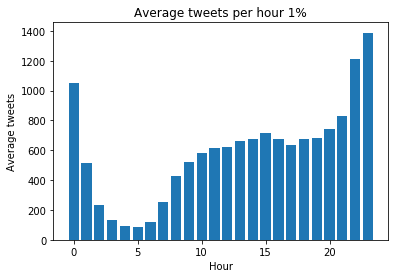

In [171]:

result = tweets_hour.rdd.map(lambda p:(p.hour, p.avg)).collect()
hours,avgs = zip(*result)

plt.bar(hours, avgs)
plt.xlabel('Hour')
plt.ylabel('Average tweets')
plt.title("Average tweets per hour 1%")
plt.show()



### **Parte 3.2:** Estratificado

En muchas ocasiones el sampling homogéneo no es adecuado ya que por la propia estructura de los datos determinados segmentos pueden estar sobrerrepresentadas. Este es el caso que observamos en los tweets donde las grandes áreas urbanas están sobrerepresentadas si lo comparamos con el volumen de población. En esta actividad vamos a ver cómo aplicar esta técnica al dataset de tweets, para obtener un sampling que respete la proporción de diputados por provincia.

En España, el proceso electoral asigna un volumen de diputados a cada provincia que depende de la población y de un porcentaje mínimo asignado por ley. En el contexto Hive que hemos creado previamente (```hiveContext```) podemos encontrar una tabla (```province_28a```) que contiene información sobre las circunscripciones electorales. Cargad ésta tabla en una variable con nombre ```province```.

In [172]:
province = hiveContext.table("province_28a")
province.limit(20).show()

+-----------+-----------+------------------+----------+---------+
|    capital|   province|              ccaa|population|diputados|
+-----------+-----------+------------------+----------+---------+
|     Teruel|     Teruel|            Aragón|     35691|        3|
|      Soria|      Soria|   Castilla y León|     39112|        2|
|    Segovia|    Segovia|   Castilla y León|     51683|        3|
|     Huesca|     Huesca|            Aragón|     52463|        3|
|     Cuenca|     Cuenca|Castilla-La Mancha|     54898|        3|
|      Ávila|      Ávila|   Castilla y León|     57697|        3|
|     Zamora|     Zamora|   Castilla y León|     61827|        3|
|Ciudad Real|Ciudad Real|Castilla-La Mancha|     74743|        5|
|   Palencia|   Palencia|   Castilla y León|     78629|        3|
| Pontevedra| Pontevedra|           Galicia|     82802|        7|
|     Toledo|     Toledo|Castilla-La Mancha|     84282|        6|
|Guadalajara|Guadalajara|Castilla-La Mancha|     84910|        3|
|      Ceu

Para hacer un sampling estratificado lo primero que tenemos que hacer es determinar la fracción que queremos asignar a cada categoría. En este caso queremos una fracción que haga que el ratio tweets diputado sea igual para todas las capitales de provincia. Tenemos que tener en cuenta que la precisión de la geolocalización en Twitter és normalmente a nivel de ciudad. Por eso, para evitar incrementar la complejidad del ejercicio, vamos a utilizar los tweets en capitales de provincia como proxy de los tweets en toda la provincia.

Lo primero que tenéis que hacer es crear un tabla ```info_tweets_province``` que debe contener:
- ***capital:*** nombre de la capital de provincia.
- ***tweets:*** número de tweets geolocalizados en cada capital
- ***diputados:*** diputados que asignados a la provincia.
- ***ratio_tweets_diputado:*** número de tweets por diputado.

Debéis ordenar la lista por ```ratio_tweets_diputado``` en orden ascendente.

***Nota:*** Podéis realizar este ejercicio de muchas maneras, probablemente la más fácil es utilizar la tabla ```tweets_place``` que habéis generado en el apartado 2.2.1. Recordad cómo utilizar el ```join()```

In [173]:
info_tweets_province=province.join(tweets_place, tweets_place.name == province.capital)\
                                .select("capital","diputados","tweets")\
                                .withColumn("ratio_tweets_diputado", tweets_place.tweets / province.diputados)\
                                .orderBy("ratio_tweets_diputado", ascending = 1)

info_tweets_province.limit(20).show()

+--------------------+---------+------+---------------------+
|             capital|diputados|tweets|ratio_tweets_diputado|
+--------------------+---------+------+---------------------+
|              Teruel|        3|    35|   11.666666666666666|
|          Pontevedra|        7|   154|                 22.0|
|              Huesca|        3|    85|   28.333333333333332|
|              Zamora|        3|    94|   31.333333333333332|
|               Soria|        2|    79|                 39.5|
|             Segovia|        3|   119|   39.666666666666664|
|              Cuenca|        3|   146|   48.666666666666664|
|               Cádiz|        9|   453|   50.333333333333336|
|         Ciudad Real|        5|   276|                 55.2|
|            Pamplona|        5|   281|                 56.2|
|                Lugo|        4|   229|                57.25|
|Santa Cruz de Ten...|        7|   471|    67.28571428571429|
|                Jaén|        5|   356|                 71.2|
|       

In [174]:
output = info_tweets_province.first()
maximum_ratio = floor(output.ratio_tweets_diputado * 100) / 100

assert output.capital == "Teruel" and output.tweets == 35 and output.diputados == 3 and maximum_ratio == 11.66, "Incorrect output"

Lo primero que vamos a necesitar es un diccionario con nombre ```ratios``` donde cada capital de provincia es una llave y su valor asociado es la fracción de tweets que vamos a samplear. En este caso lo que queremos es que el ratio de tweets por cada diputado sea similar para cada capital de provincia.

Como queremos que el sampling sea lo más grande posible y no queremos que ninguna capital este infrarepresentada el ratio de tweets por diputado será el valor más pequeño podéis observar en la tabla ```info_tweets_province```, que corresponde a 11.66 tweets por diputado en Teruel. Tenéis este valor guardado en la variable ```maximum_ratio```.

*Nota:* El método ```collectAsMap()``` transforma un PairRDD en un diccionario.

In [175]:

ratios_tweets = info_tweets_province.select("capital","ratio_tweets_diputado").withColumn("ratios", maximum_ratio/info_tweets_province.ratio_tweets_diputado)
print(ratios_tweets.limit(3).show())
ratios = ratios_tweets.select("capital", "ratios").rdd.collectAsMap()                   
print(ratios["Teruel"])

+----------+---------------------+------------------+
|   capital|ratio_tweets_diputado|            ratios|
+----------+---------------------+------------------+
|    Teruel|   11.666666666666666|0.9994285714285714|
|Pontevedra|                 22.0|              0.53|
|    Huesca|   28.333333333333332|0.4115294117647059|
+----------+---------------------+------------------+

None
0.9994285714285714


Generad una tabla ```geo_tweets``` con los tweets geolocalizados.

In [176]:
geo_tweets = tweets.where("place IS NOT NULL").select("place.name", "text")

Ahora ya estamos en disposición de hacer el sampling estratificado por población. Para ello podéis utilizar el método ```sampleBy()```. Utilizad 42 como seed del generador pseudoaleatorio.

In [177]:
seed = 42
sample = geo_tweets.sampleBy("name", ratios, seed)
sample.limit(20).show()


+--------------------+--------------------+
|                name|                text|
+--------------------+--------------------+
|Castellón de la P...|@orilatz @garcija...|
|            Palencia|@CiudadanosCs @To...|
|           Barcelona|Us juro que aques...|
|            Alicante|@Trismegista Solo...|
|              Cuenca|Clarinete, Sr. Ru...|
|                León|📅 Hoy empezaremo...|
|             Segovia|     #ApagaLaSexta #|
|             Sevilla|   Manipulado.
FAKE.|
|            Valencia|¿Que no sabes si ...|
|              Málaga|Marine Le Pen del...|
|              Madrid|“¿De qué coño sab...|
|               Cádiz|Si esta caradura ...|
|           Barcelona|Yo aseguro que il...|
|              Murcia|@Karma13355592 #H...|
|             Córdoba|@gabrielrufian @I...|
|          Pontevedra|@pablocasado_    ...|
|                León|Que así sea !!! #...|
|Santa Cruz de Ten...|Voy a usar las hi...|
|              Murcia|Ya llega el desfi...|
|                Lugo|@miquinta1 

Para visualizar el resultado del sampling vais a crear una tabla ```info_sample``` que contenga la siguiente información:
- ***capital:*** nombre de la capital de provincia.
- ***tweets:*** número de tweets sampleados en cada capital
- ***diputados:*** diputados que asignados a la provincia.
- ***ratio_tweets_diputado:*** número de tweets por diputado.

Ordenad la tabla resultante por orden de ```ratio_tweets_diputado```

In [178]:


info_sample = province.join(sample, sample.name == province.capital)\
                                .select("capital","diputados")\
                                .groupBy("capital", "diputados")\
                                .agg({"capital": "count"})\
                                .withColumnRenamed("count(capital)", "tweets")

info_sample = info_sample.withColumn("ratio_tweets_diputado", info_sample.tweets / province.diputados)\
                                .orderBy("ratio_tweets_diputado", ascending = 1)
                                

info_sample.limit(20).show()

+---------------+---------+------+---------------------+
|        capital|diputados|tweets|ratio_tweets_diputado|
+---------------+---------+------+---------------------+
|        Melilla|        1|     6|                  6.0|
|          Ceuta|        1|     8|                  8.0|
|    Ciudad Real|        5|    44|                  8.8|
|           León|        4|    38|                  9.5|
|       Albacete|        4|    39|                 9.75|
|         Bilbao|        8|    79|                9.875|
|         Zamora|        3|    30|                 10.0|
|    Guadalajara|        3|    30|                 10.0|
|       Palencia|        3|    30|                 10.0|
|       Alicante|       12|   122|   10.166666666666666|
|      Tarragona|        6|    62|   10.333333333333334|
|           Lugo|        4|    42|                 10.5|
|        Segovia|        3|    32|   10.666666666666666|
|         Toledo|        6|    64|   10.666666666666666|
|       Pamplona|        5|    

In [179]:
output = info_sample.first()
assert output.capital == "Melilla" and output.tweets == 6 and output.diputados == 1 and output.ratio_tweets_diputado == 6.0, "Incorrect output"

Como veis el sampling no es exacto, es una aproximación. Pero como podéis imaginar acercar el sampling a la representatividad electoral de las regiones son necesarios en muchos análisis.

Para comprobarlo contad primero todos los hashtags presentes en la tabla ```geo_tweets``` tal como hemos hecho en el apartado 2.2.2 y ordenad el resultado por número de tweets en orden descendente

In [181]:

hashtags_geo = geo_tweets.rdd.flatMap(lambda x: re.findall(r"(#\w+)", x.text)) \
.map(lambda x: (x, 1)).reduceByKey(add)

hashtags_geo.take(10)

[('#26Abril', 7),
 ('#EscribamosLaHistoria', 1),
 ('#CamíALaRepública', 1),
 ('#UnMundoDeSensaciones', 1),
 ('#Bcn', 1),
 ('#Pedagogía', 1),
 ('#elche', 1),
 ('#MESA', 1),
 ('#porlosderechosdeTODOS', 1),
 ('#TaxiEnLucha', 8)]

Comparad este resultado con el que obtenemos cuando creamos una tabla ```hashtagsTable_sample``` donde contamos los hashtags en el sample. Ordenad la tabla por número de tweets en orden descendente.

In [183]:
hashtagsTable_sample = hashtags_geo.toDF(["hashtag", "num"]).orderBy("num", ascending=0)
hashtagsTable_sample.limit(20).show()

+--------------------+----+
|             hashtag| num|
+--------------------+----+
|                #28A|7417|
|   #ElDebateDecisivo|3942|
|     #ELDEBATEenRTVE|3514|
|     #EquiparacionYa|2309|
|       #6AbrilMadrid|1839|
|         #ILPJusapoL|1762|
|         #HazQuePase|1622|
|#EleccionesGenera...|1478|
|       #EleccionesL6| 988|
|        #ValorSeguro| 864|
|   #DebateAtresmedia| 847|
|#LaHistoriaLaEscr...| 752|
|           #VotaPSOE| 701|
|         #DebateRTVE| 699|
| #LaEspañaQueQuieres| 658|
|#EleccionesGenerales| 653|
|    #VamosCiudadanos| 598|
|           #DebatTV3| 597|
|             #España| 580|
|            #28Abril| 571|
+--------------------+----+



## **Parte 4:** Introducción a los datos relacionales

El hecho de trabajar con una base de datos que contiene información generada en una red social nos permite introducir el concepto de datos relacionales. Podemos definir datos relacionales como aquellos en los que existen relaciones entre las entidades que constituyen la base de datos. Si estas relaciones son binarias, relaciones 1 a 1, podemos representar las relaciones como un grafo compuesto por un conjunto de vértices $\mathcal{V}$ y un conjunto de aristas $\mathcal{E}$ que los relacionan.

En el caso de grafos que emergen de manera orgánica, este tipo de estructura va más allá de los grafos regulares que seguramente conocéis. Este tipo de estructuras se conocen como [redes complejas](https://es.wikipedia.org/wiki/Red_compleja). El estudio de la estructura y dinámicas de este tipo de redes ha contribuido a importantes resultados en campos tan dispares como la física, la sociología, la ecología o la medicina.

![complex_network](https://images.squarespace-cdn.com/content/5150aec6e4b0e340ec52710a/1364574727391-XVOFAB9P6GHKTDAH6QTA/lastfm_800_graph_white.png?content-type=image%2Fpng)

En esta última parte de la práctica vamos ha trabajar con este tipo de datos. En concreto vamos a modelar uno de los posibles relaciones presentes en el dataset, la red de retweets.

### **Parte 4.1:** Generar la red de retweets

#### **Parte 4.1.1**: Construcción de la edgelist

Lo primero se os pide es que generéis la red. Hay diversas maneras de representar una red compleja, por ejemplo, si estuvierais interesados en trabajar en ellas desde el punto de vista teórico, la manera más habitual de representarlas es utilizando una [matriz de adyacencia](https://es.wikipedia.org/wiki/Matriz_de_adyacencia). En esta práctica vamos a centrarnos en el aspecto computacional, una de las maneras de mas eficientes (computacionalmente hablando) de representar una red es mediante su [*edge list*](https://en.wikipedia.org/wiki/Edge_list), una tabla que especifica la relación a parejas entre las entidades.

Las relaciones pueden ser bidireccionales o direccionales y tener algún peso asignado o no (weighted or unweighted). En el caso que nos ocupa, estamos hablando de una red dirigida, un usuario retuitea a otro, y podemos pensarla teniendo en cuenta cuántas veces esto ha pasado.

Lo primero que haréis para simplificar el cómputo,  es crear un sample homogéneo sin reemplazo del 1% de los tweets. Utilizando los conocimientos que habéis aprendido en el apartado 3.1. Utilizaremos 42 como valor para la seed.

In [184]:
seed=42
fraction = 0.01
sample = tweets.sample(False, fraction, seed)

Ahora vais a crear una tabla ```edgelist``` con la siguiente información:
- ***src:*** usuario que retuitea
- ***dst:*** usuario que es retuiteado
- ***weight:*** número de veces que un usuario retuitea a otro.

Filtrar el resultado para que contenga sólo las relaciones con un weight igual o mayor a dos.

In [185]:
from pyspark.sql.functions import col
edgelist= sample.where("retweeted_status IS NOT NULL").select( col("user.screen_name").alias("src"),col("retweeted_status.user.screen_name").alias("dst"))\
.groupBy("src","dst").agg({"dst": "count"})\
.withColumnRenamed("count(dst)", "weight")

edgelist = edgelist.where("weight >1")
#edgelist.limit(20).show()
L = edgelist.count()

print("There are {0} edges on the network.".format(L))

There are 5247 edges on the network.


In [186]:
assert L == 5247, "Incorrect ouput"

#### **Parte 4.1.2:** Centralidad de grado

Uno de los descriptores más comunes en el análisis de redes es el grado. El grado cuantifica cuántas aristas están conectadas a cada vértices. En el caso de redes dirigidas como la que acabamos de crear este descriptor está descompuesto en el:
- **in degree**: cuantas aristas apuntan al nodo
- **out degree**: cuantas aristas salen del nodo

Si haces un ranquing de estos valores vais a obtener medida de centralidad, la [centralidad de grado](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), de cada uno de los nodos.

Se os pide que generéis una tabla con la información:
- ***screen_name:*** nombre del usuario.
- ***outDegree:*** out degree del nodo.

Ordenado la tabla por out degree en orden descendente.

In [187]:
outDegree = edgelist.select("src", "weight").groupBy("src").agg({"weight": "count"})\
.withColumnRenamed("count(weight)", "outDegree")\
.withColumnRenamed("src", "screen_name")\
.orderBy("outDegree", ascending=0)

outDegree.limit(20).show()

+---------------+---------+
|    screen_name|outDegree|
+---------------+---------+
|   rosavergar23|       11|
|JulioAl18175505|       10|
|      el_partal|       10|
|    SSarelvis67|        9|
|Teresaperezcep1|        8|
|miguelgutiperez|        8|
|       anap1958|        8|
|      MACUBERNA|        7|
|  yomismaconcha|        7|
|        Fermirv|        7|
|    pacomarina6|        7|
|   Socialista60|        7|
|     astroman78|        7|
|       jasalo54|        7|
|  Rafa_eltorete|        7|
|        lyuva26|        7|
|    mercedescdz|        6|
|        crg1212|        6|
|  joanagabarrof|        6|
|     carrasquem|        6|
+---------------+---------+



In [188]:
output = outDegree.first()
assert output.screen_name == "rosavergar23" and output.outDegree == 11, "Incorrect output"

Se os pide ahora que generéis una tabla con la información:
- ***screen_name:*** nombre del usuario.
- ***inDegree:*** in degree del nodo.

Ordenad la tabla por in degree en orden descendente.

In [189]:
inDegree = edgelist.select("dst", "weight").groupBy("dst").agg({"weight": "count"})\
.withColumnRenamed("count(weight)", "inDegree")\
.withColumnRenamed("dst", "screen_name")\
.orderBy("inDegree", ascending=0)

inDegree.limit(20).show()

+---------------+--------+
|    screen_name|inDegree|
+---------------+--------+
|         vox_es|     330|
|   ahorapodemos|     279|
|           PSOE|     242|
|   CiudadanosCs|     218|
|  Santi_ABASCAL|     163|
|      populares|     119|
|Pablo_Iglesias_|     109|
|  AlbanoDante76|      95|
|Front_Republica|      89|
|           KRLS|      86|
|sanchezcastejon|      79|
|      JuntsXCat|      70|
|       iescolar|      66|
|         boye_g|      55|
| AntonioMaestre|      52|
|   pablocasado_|      48|
|       ivanedlm|      46|
| hermanntertsch|      42|
|    CastigadorY|      40|
|     eldiarioes|      37|
+---------------+--------+



In [190]:
output = inDegree.first()
assert output.screen_name == "vox_es" and output.inDegree == 330, "Incorrect output"

### **Part 4.2:** Graphframes

Este tipo de estructuras es muy común en muchos datasets y su análisis cada vez se ha vuelto más habitual. Para simplificar las operaciones y el análisis vamos a utilizar una librería específicamente diseñada para trabajar en redes en sistemas distribuidos: [**Graphframes**](https://graphframes.github.io/graphframes/docs/_site/index.html).

In [191]:
import sys
pyfiles = str(sc.getConf().get(u'spark.submit.pyFiles')).split(',')
sys.path.extend(pyfiles)
from graphframes import *

#### **Parte 4.2.1:** Crear un graph frame

Lo primero que vamos ha hacer es crear un objeto ```GraphFrame``` que contendrà toda la información de la red.

En un paso previo ya hemos creado la *edge list* ahora vamos a crear una lista con los vértices. Crear una tabla ```vértices``` que contenga una única columna ```id``` con los nombre de usuario de todos los vértices. Recordad que hay vértices que puede que solo tengan aristas incidentes y otros que puede que no tengan (tenéis que utilizar la información de ambas columnas de la ```edgelist```). Recordad que la lista de vértices es un conjunto donde no puede haber repetición de identificadores.

In [192]:
vertices = edgelist.select(col("src").alias("id")).union(edgelist.select(col("dst").alias("id"))).distinct()
N = vertices.count()
print("There are {0} nodes on the network.".format(N))

There are 5111 nodes on the network.


In [193]:
assert N == 5111, 'Incorrect output'

Al igual que con las aristas, podéis asignar atributos a los vértices. Completad la tabla ```vertices``` haciendo un *inner join* por ```id``` con la tabla ```user_info``` guardada en el contexto ```hiveContext```.

In [194]:
user_info =  hiveContext.table("user_info")
vertices = vertices.join(user_info, "id")

vertices.limit(20).show()

+---------------+----+------+------------+---------+---------+
|             id|lang|tweets|total_tweets|following|followers|
+---------------+----+------+------------+---------+---------+
|     __akasha__|  es|   126|        5225|      576|      180|
|     NoEsPotCat|  ca|   126|       13294|     1163|     6076|
|      elisabeni|  es|    95|       89330|     1170|   110432|
| GirautaOficial|  es|   190|       17293|     1960|    97179|
|   Asturgalicia|  es|  2137|      100752|     5002|     2976|
|    voxpalencia|  es|   260|        4322|      540|     1662|
|DavidMa33922012|  es|   516|        5954|      231|      174|
|       CsFerrol|  es|   317|       15464|      936|     2193|
|    besoviajero|  es|  1494|       57882|     1372|     1397|
|      Montsecs3|  en|    83|         148|       58|        1|
|AnaFern52249672|  es|  1468|       73972|       31|      198|
|IsadoraArtemisa|  es|   265|        5211|      630|      440|
|       alrolsan|  es|   306|       14053|     3023|   

Una vez tenemos la edgelist y la lista de edges estamos en disposición de instanciar [un objecto ```GraphFrame```](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html). Instanciad este objeto en la variable ```network```.

In [195]:


network = GraphFrame(vertices, edgelist)


El objeto que acabais de crear tiene muchas atributos y métodos para el analisis de redes [(comprobad el API)](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html). Se os pide que utilizéis el atributo ```inDegrees``` para, conjuntamente con la transformación ```orderBy```, mostrar la informació del in degree en orden descendente.

In [196]:
calculated_indegree= network.inDegrees.orderBy("inDegree", ascending=0)
calculated_indegree.limit(20).show()

+---------------+--------+
|             id|inDegree|
+---------------+--------+
|         vox_es|     330|
|   ahorapodemos|     279|
|           PSOE|     242|
|   CiudadanosCs|     218|
|  Santi_ABASCAL|     163|
|      populares|     119|
|Pablo_Iglesias_|     109|
|  AlbanoDante76|      95|
|Front_Republica|      89|
|           KRLS|      86|
|sanchezcastejon|      79|
|      JuntsXCat|      70|
|       iescolar|      66|
|         boye_g|      55|
| AntonioMaestre|      52|
|   pablocasado_|      48|
|       ivanedlm|      46|
| hermanntertsch|      42|
|    CastigadorY|      40|
|     eldiarioes|      37|
+---------------+--------+



Haced lo mismo con el atributo ```outDegrees``` para, conjuntamente con la transformación ```orderBy```, mostrar la informació del out degree en orden descendente.

In [197]:
calculated_outdegree= network.outDegrees.orderBy("outDegree", ascending=0)
calculated_outdegree.limit(20).show()

+---------------+---------+
|             id|outDegree|
+---------------+---------+
|   rosavergar23|       11|
|JulioAl18175505|       10|
|      el_partal|       10|
|    SSarelvis67|        9|
|Teresaperezcep1|        8|
|miguelgutiperez|        8|
|       anap1958|        8|
|      MACUBERNA|        7|
|  yomismaconcha|        7|
|        Fermirv|        7|
|    pacomarina6|        7|
|   Socialista60|        7|
|     astroman78|        7|
|       jasalo54|        7|
|  Rafa_eltorete|        7|
|        lyuva26|        7|
|    mercedescdz|        6|
|        crg1212|        6|
|  joanagabarrof|        6|
|     carrasquem|        6|
+---------------+---------+



#### **Parte 4.2.2:** Centralidad PageRank

Hasta ahora hemos visto uno de los descriptores más básicos del análisis de redes, la centralidad de grado. Ahora vamos a aprovechar las funcionalidades de GraphFrames para estudiar [la centralidad del *PageRank*](https://en.wikipedia.org/wiki/PageRank), el algoritmo original que utilizaba Google para indexar la web.

La idea detrás de este algoritmo es representar la reputación. Google pensaba que no solo es importante saber cuántos enlaces apuntan a una web, sino también su importancia. Para analizarlo crearon este algoritmo que básicamente queda formalmente representado por:
$$
\mbox{PR}(p_i) = \frac{1 - d}{N} + d \sum_{p_j \in M(p_i)}\frac{\mbox{PR}(p_j)}{L(p_j)}
$$
Donde $\mbox{PR}(p_i)$ representa el PageRank de la página $p_i$, $d$ es un factor de amortiguación, $p_j$ es una página que enlaza $p_i$ y $L(p_j)$ es el numero total de enlaces salientes de la página $j$. Como podéis ver es un algoritmo recursivo, que se puede resolver de diferentes maneras.

Afortunadamente, no tendréis que preocuparos por la implementación ya que la classe GraphFrames implementa un método ```pageRank``` para calcularlo. Cread una tabla ```page_rank``` con los resultados. Mostrad los resultados con el ```id``` del nodo y su indice ```PageRank``` en orden descendente

- ***Nota 1:*** Utilizando los parametros del metodo tenéis que fijar la probabilidad de reinicio a 0.15 y el numero máximo de iteraciones a 5
- ***Nota 2:*** El tiempo de cómputo puede oscilar de 3 a 20 minutos dependiendo de la carga del servidor.

In [208]:
page_rank = network.pageRank(resetProbability=0.15, maxIter=5)


In [211]:
page_rank.vertices.select("id","pagerank").orderBy("pagerank", ascending=0).limit(20).show()

+---------------+------------------+
|             id|          pagerank|
+---------------+------------------+
|         vox_es|170.31097167053235|
|Pablo_Iglesias_|120.80247412776232|
|  Santi_ABASCAL|102.41446139478607|
|   ahorapodemos| 100.2837043688577|
| hermanntertsch|  95.4113047882803|
|   CiudadanosCs|   93.245766612301|
|           PSOE| 91.13458970143508|
|  InesArrimadas|47.359707863261676|
| RaiLopezCalvet| 47.34108812182462|
|  Albert_Rivera| 47.31355661690909|
|        ehbildu| 44.45332094685276|
|      populares|41.608475611135525|
|  AlbanoDante76| 34.74766697076182|
|Front_Republica| 33.79746007120636|
|Front_Republica| 33.79746007120636|
|        Jjsb441|31.125164754674714|
|           KRLS| 30.45209286696975|
|sanchezcastejon| 27.33777199805432|
|      JuntsXCat| 26.74753185335384|
|       iescolar|24.662781385904097|
+---------------+------------------+



¿Observáis alguna diferencia con los resultados de importancia del out degree?¿A que creéis que se debe?